In [1]:
%%sh
pip install pydot
pip install tqdm
pip install pydotplus

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import nltk
nltk.download('stopwords')  

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import numpy as np 
import pandas as pd

In [4]:
%load_ext autoreload
%autoreload 2

# helper python file
import ml_pipeline as pipeline

Using TensorFlow backend.


In [5]:
#import the required libraries
import keras
from keras.layers import Embedding
from keras.layers import Dense, Flatten, LSTM
from keras.layers import Input, GlobalMaxPool1D, Dropout
from keras.layers import Activation
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras import optimizers

import os
import pandas as pd

In [6]:
(train_df,test_df)=pipeline.read_input_data()

num train:  159571
num test:  153164


In [7]:
(seq_test,seq_train,word_index)=pipeline.tokenize_data(test_df,train_df)
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

  2%|▏         | 3360/153164 [00:00<00:04, 33589.46it/s]

pre-processing train data...


100%|██████████| 159571/159571 [00:04<00:00, 32296.64it/s]


tokenizing input data...
dictionary size:  348520


In [8]:
EMBEDDING = 'Glove-Twitter'
embedding_matrix=pipeline.prepare_embeddings(EMBEDDING,word_index)

1193514it [01:13, 16128.65it/s]


preparing embedding matrix...
number of null word embeddings: 1656


In [9]:
max_features=20000
max_seq_len=150

In [10]:
def init_BiLSTM_model(embedding_matrix):
    model = Sequential()
    model.add(Embedding(max_features, embedding_matrix.shape[1], weights = [embedding_matrix], input_length = max_seq_len, trainable = False))
    model.add(Bidirectional(LSTM(50, return_sequences = True)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(50, activation = "relu"))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.1))
    model.add(Dense(6, activation = 'sigmoid'))
    model.summary()
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(lr = 0.01, decay = 0.01/32), metrics = ['accuracy'])
    return model

In [11]:
model=init_BiLSTM_model(embedding_matrix)











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 200)          4000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 100)          100400    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________

In [13]:
from keras.utils import plot_model
plot_model(model,
           to_file='images/bilstm_model.png',
           show_shapes=True,
           show_layer_names=True)

In [16]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "images/bilstm_model.png")

In [15]:
#fit the modael on the dataset
history = model.fit(seq_train, y_train, epochs = 5, batch_size = 128, validation_split = 0.2)

Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 439s 3ms/step - loss: 0.0550 - acc: 0.9802 - val_loss: 0.0484 - val_acc: 0.9819
Epoch 2/5
127656/127656 [==============================] - 438s 3ms/step - loss: 0.0482 - acc: 0.9820 - val_loss: 0.0463 - val_acc: 0.9826
Epoch 3/5
127656/127656 [==============================] - 438s 3ms/step - loss: 0.0451 - acc: 0.9828 - val_loss: 0.0461 - val_acc: 0.9831
Epoch 4/5
127656/127656 [==============================] - 439s 3ms/step - loss: 0.0429 - acc: 0.9834 - val_loss: 0.0453 - val_acc: 0.9830
Epoch 5/5
127656/127656 [==============================] - 438s 3ms/step - loss: 0.0403 - acc: 0.9842 - val_loss: 0.0483 - val_acc: 0.9834


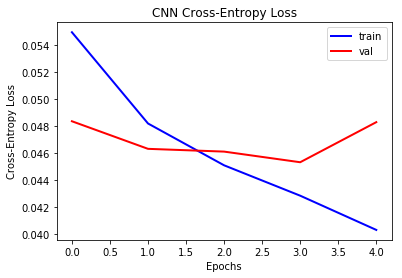

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt

#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

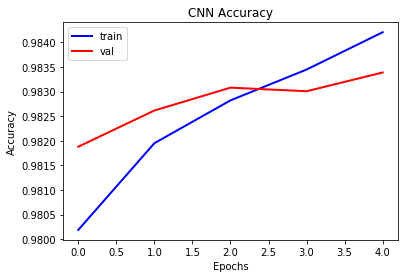

In [19]:
plt.figure()
plt.plot(history.history['acc'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [20]:
y_test = model.predict(seq_test)
pipeline.create_submission_file(test_df,y_test,'bilstm_glove_twitter_submission.csv')